 # [Module 2.3] CatBoost 훈련 및 추론

이 노트북은 아래와 같은 작업을 합니다.
- 훈련, 검증 데이터 로딩
- Category 인덱스 추출
- CatBoost 훈련
- 테스트 데이터 로딩 및 추론
- 모델 평가
- 피쳐 Importance 생성

In [365]:
import pandas as pd

In [366]:
%store -r pre_train_file
%store -r pre_val_file
%store -r pre_test_file

## 훈련, 검증 데이터 세트 로딩

In [367]:
train_df = pd.read_csv(pre_train_file, header=None, skiprows=1)
val_df = pd.read_csv(pre_val_file, header=None, skiprows=1)
print("train_df: ", train_df.shape)
print("val_df: ", val_df.shape)

train_df:  (53740, 19)
val_df:  (13436, 19)


In [368]:
from IPython.display import display
display(train_df.head())
display(val_df.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,3,2649,25,232,29.99,10.96,9000.0,2640.0,1,4,10,5.074929,313.325175,80621.001131,704.106277,289.234266,5.980614,35917.001966,5.074929
1,2,764,12,9194,23.90,26.82,1500.0,14625.0,1,4,10,4.074929,7805.012365,80621.001131,204.396123,40.117269,4.074929,614.204570,4.074929
2,4,295,10,3775,249.90,17.59,610.0,4928.0,1,4,10,30.244957,3742.023214,4961.018757,952.093106,909.097046,43.210375,794.132442,6.074929
3,4,2410,18,2562,89.90,17.51,1850.0,10764.0,1,4,10,6.074929,4962.018970,80621.001131,27766.003039,48.037464,110.726225,10004.011425,6.074929
4,2,2174,18,2141,93.90,17.61,1200.0,12500.0,1,4,10,4.074929,7805.012365,9777.011006,31.405597,31.405597,4.074929,1050.110874,4.074929


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,3,1372,23,10728,105.00,23.89,1000.0,7632.0,1,19,6,260.375634,6506.014877,4961.018757,2484.036771,365.281119,17.815563,175.544669,4.34846
1,0,784,25,11737,99.97,15.80,650.0,9600.0,1,19,6,7.728837,6718.013196,10105.010047,391.201729,116.495153,5.074929,3818.025616,4.34846
2,3,2660,18,2837,76.99,23.34,1850.0,3000.0,1,19,6,7.728837,262.279317,80621.001131,27766.003039,67.764447,32.281574,10004.011425,4.34846
3,2,2174,18,2060,64.90,15.55,200.0,4752.0,1,19,6,7.728837,4962.018970,80621.001131,27766.003039,113.580980,1866.058804,10004.011425,4.34846
4,4,2820,7,3350,75.00,27.51,2550.0,31500.0,1,19,6,28.361672,7805.012365,80621.001131,27766.003039,929.098360,139.613711,1772.067347,4.34846


In [369]:
X_train, y_train = train_df.iloc[:,1:], train_df.iloc[:,0]
X_val, y_val = val_df.iloc[:,1:], val_df.iloc[:,0]

In [370]:
X_train[X_train.iloc[:,1] == 25]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,2649,25,232,29.99,10.96,9000.0,2640.0,1,4,10,5.074929,313.325175,80621.001131,704.106277,289.234266,5.980614,35917.001966,5.074929
9,1986,25,860,149.99,11.66,900.0,8000.0,3,6,10,15.742940,286.292440,80621.001131,27766.003039,1458.052372,22.502535,35917.001966,4.074929
11,1431,25,851,294.90,20.34,795.0,11700.0,3,6,10,4.074929,4311.021183,9777.011006,477.195397,5.894500,4.074929,4395.023301,4.074929
14,276,25,7799,139.90,21.34,2500.0,10179.0,3,6,10,4.980614,7805.012365,10105.010047,305.302594,305.302594,4.074929,3818.025616,4.074929
16,2386,25,826,29.90,10.96,300.0,704.0,3,6,10,6.074929,5082.018685,80621.001131,27766.003039,48.037464,71.806917,35917.001966,6.074929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53732,2495,25,3571,108.90,11.78,1850.0,5168.0,1,19,6,12.361672,4311.021183,80621.001131,176.348588,175.351399,14.210375,35917.001966,3.074929
53734,2386,25,830,107.50,13.41,4600.0,7200.0,1,19,6,4.074929,11800.008534,80621.001131,8641.013176,8641.013176,38.210375,35917.001966,7.980614
53737,2495,25,6993,99.99,12.43,1700.0,19500.0,1,19,6,90.660205,200.360112,80621.001131,1278.061982,110.588831,119.337779,35917.001966,2.074929
53738,2381,25,11469,129.00,19.00,501.0,3276.0,1,19,6,33.452450,6506.014877,10105.010047,14.742940,6.980614,6.074929,3818.025616,6.074929


## 레이블 인코딩된 category 인덱스 추출
- CatBoost 알고리즘에 category 인덱스를 알려 주기 위해서 임

In [371]:
cat_features_index = X_train.columns[X_train.dtypes == 'int64'].tolist()
cat_features_index = [num -1 for num in cat_features_index]
cat_features_index

[0, 1, 2, 7, 8, 9]

## CatBoost 훈련


In [372]:
%%time 

import catboost as cb

clf = cb.CatBoostClassifier(eval_metric="Accuracy",max_depth=5,
                           iterations = 500)
# clf.fit(X_train, y_train, verbose=False, cat_features = cat_features_index)
clf.fit(X_train, y_train, verbose=False)


CPU times: user 1min 18s, sys: 6.4 s, total: 1min 25s
Wall time: 23.7 s


In [373]:
clf.score(X_val, y_val)

0.33566537660017864

## Train 과 Val를 합쳐서 훈련 (Train_Val)

In [374]:
# def concatenate_train_val(X_train, y_train, X_val, y_val):
#     X_train_val = pd.concat([X_train, X_val], axis=0)
#     print("X_train_val: ", X_train_val.shape)
#     y_train_val = pd.concat([y_train, y_val], axis=0)    
#     print("y_train_val: ", y_train_val.shape)    
    
#     return X_train_val, y_train_val

# X_train_val, y_train_val = concatenate_train_val(X_train, y_train, X_val, y_val)
# clf = cb.CatBoostClassifier(eval_metric="Accuracy",max_depth=5,
#                            iterations = 500)
# clf.fit(X_train_val, y_train_val, verbose=False)



## Test 데이터로 평가

In [375]:
test_df = pd.read_csv(pre_test_file, header=None,skiprows=1)
test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,3,1372,23,10728,105.00,23.89,1000.0,7632.0,1,19,6,260.375634,6506.014877,4961.018757,2484.036771,365.281119,17.815563,175.544669,4.34846
1,0,784,25,11737,99.97,15.80,650.0,9600.0,1,19,6,7.728837,6718.013196,10105.010047,391.201729,116.495153,5.074929,3818.025616,4.34846
2,3,2660,18,2837,76.99,23.34,1850.0,3000.0,1,19,6,7.728837,262.279317,80621.001131,27766.003039,67.764447,32.281574,10004.011425,4.34846
3,2,2174,18,2060,64.90,15.55,200.0,4752.0,1,19,6,7.728837,4962.018970,80621.001131,27766.003039,113.580980,1866.058804,10004.011425,4.34846
4,4,2820,7,3350,75.00,27.51,2550.0,31500.0,1,19,6,28.361672,7805.012365,80621.001131,27766.003039,929.098360,139.613711,1772.067347,4.34846


In [376]:
X_test, y_test = test_df.iloc[:,1:], test_df.iloc[:,0]

In [377]:
prediction = clf.predict(X_test)

## 모델 평가

In [378]:
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test, prediction)
f1_score = f1_score(y_test, prediction, average='macro')
print("accuracy: %.2f%%" % accuracy)
print("f1_score: %.2f%%" % f1_score)

accuracy: 0.34%
f1_score: 0.12%


[[  48   29 1615    8    5]
 [  22   60 4006   40   34]
 [  10   27 4365   84   49]
 [   0    5 2112   30   21]
 [   1    2  849    7    7]]


<Figure size 432x288 with 0 Axes>

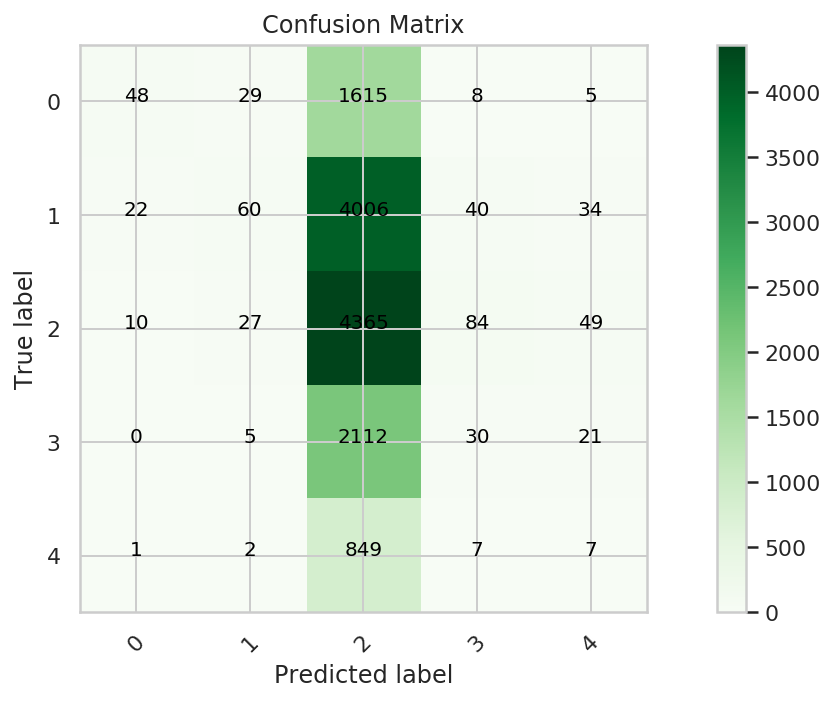

In [379]:
from utils import plot_conf_mat


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

cm = confusion_matrix(y_true= y_test, y_pred= prediction)

plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(cm, 
              classes=['0','1', '2', '3', '4'], 
              title='Confusion Matrix')
plt.show()

## Feature Importance

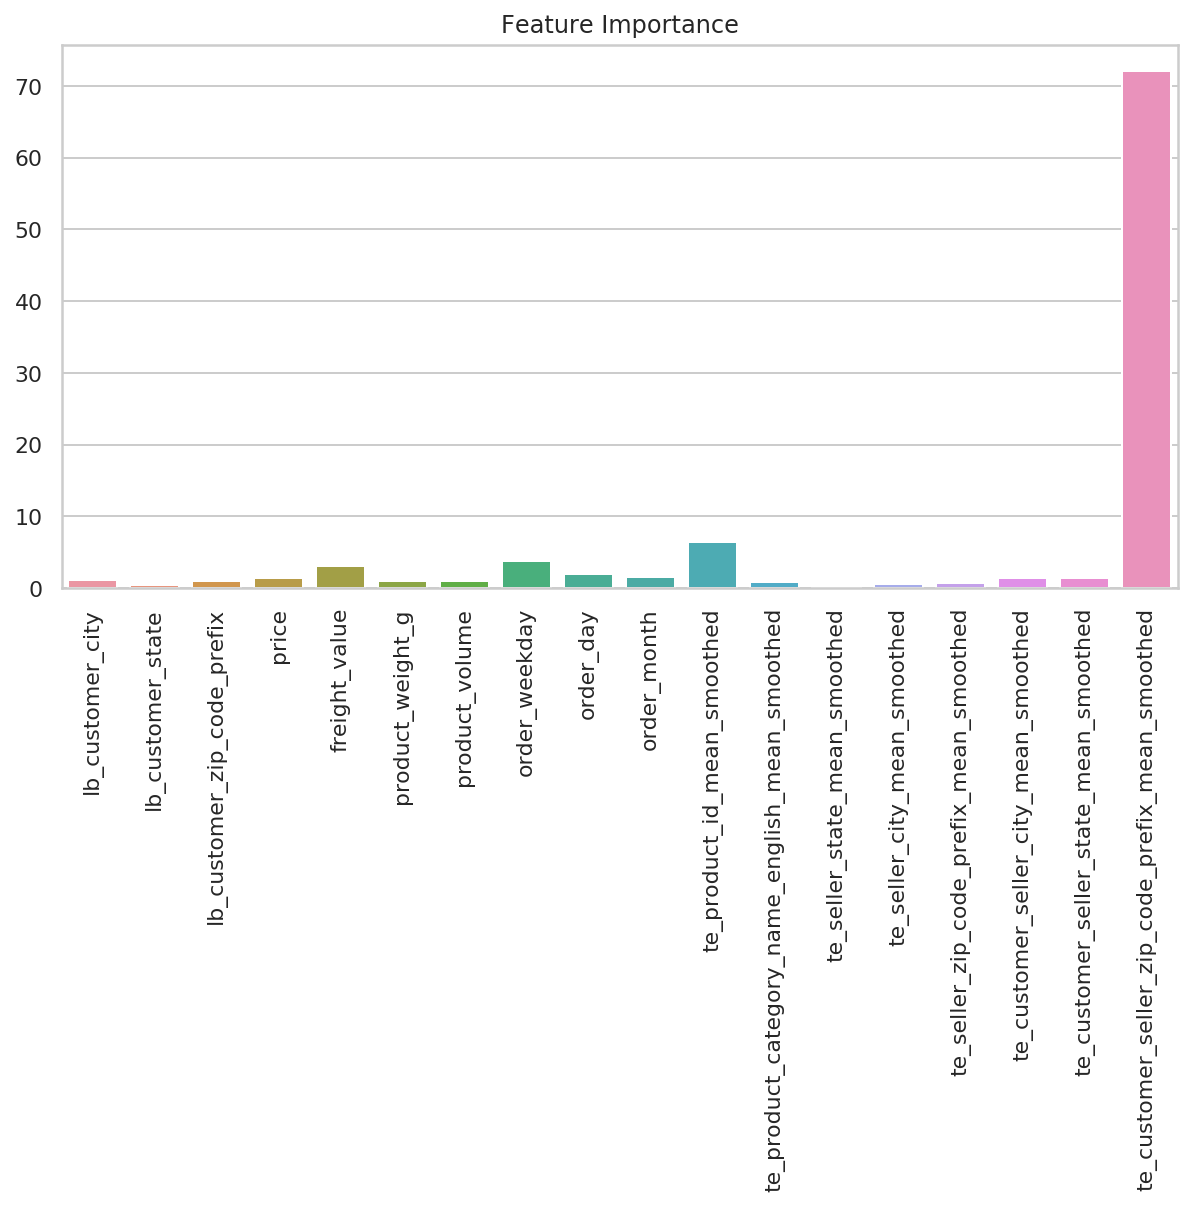

In [380]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")


test_col_df = pd.read_csv(pre_test_file)
features = test_col_df.columns[1:]
fea_importance = clf.feature_importances_

f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=features, y= fea_importance)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()